## 1. setup

In [35]:
from datetime import datetime as dt
import csv, os, glob
from pprint import pprint

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold
from scipy import interp

import tensorflow.keras as k
from tensorflow.math import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

import cv2

# load tensorboard
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [36]:
def draw_CM(label, predicted):
    cm = confusion_matrix(label, predicted)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    # true : false rate
    true = 0
    false = 0
    for i, j in enumerate(label):
        if j != predicted[i]:
            false += 1
        else: true += 1

    classification_report = metrics.classification_report(label, predicted)
    multilabel_to_binary_matrics = metrics.multilabel_confusion_matrix(label, predicted)

    return plt.show(), print('true rate: ', true), print('false rate: ', false), print(), print('='*10, 'classification_report: ', '\n', classification_report), print('='*10, 'multilabel_to_binary_matrics by class_num: ','\n','[[TN / FP] [FN / TP]]','\n', multilabel_to_binary_matrics)
    
def draw_ROC_AUC(x, y, category_names):
    n_classes = len(category_names)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], x[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), x.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
            label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})', 
            color='deeppink', linestyle=':', linewidth=1)

    plt.plot(fpr["macro"], tpr["macro"],
            label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
            color='navy', linestyle=':', linewidth=1)

    colors = (['purple', 'pink', 'red', 'green', 'yellow', 'cyan', 'magenta', 'blue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=1, label=f'Class {i} ROC curve (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([-.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC & AUC')
    plt.legend(loc="lower right")

    return plt.show()

In [37]:
# path
path = "/home/z/PycharmProjects/gap_model/in/_annotations.csv"
df = pd.read_csv(path)
df = df[['filename', 'xmin', 'ymin', 'xmax', 'xmax']]
print(df)

                                                filename  xmin  ymin  xmax  \
0      acqui4_imag2_3850_png.rf.1f46d8e1abc87614273d1...    46    53    64   
1      acqui4_imag2_3850_png.rf.1f46d8e1abc87614273d1...     8     0    29   
2      acqui4_imag2_1474_png.rf.1f46cccce5aa89dd498cc...    10    33    29   
3      acqui4_imag2_1474_png.rf.1f46cccce5aa89dd498cc...    50    37    73   
4      acqui5_image_525_png.rf.1fa445144d951bacf962d1...    46    17    66   
...                                                  ...   ...   ...   ...   
11743  acqui2_image_1185_png.rf.be42d1e782b4ed649c6b5...    59    17    76   
11744  acqui2_image_1185_png.rf.be42d1e782b4ed649c6b5...    48    30    64   
11745  acqui2_image_1185_png.rf.be42d1e782b4ed649c6b5...    10    33    28   
11746  acqui2_image_1185_png.rf.be42d1e782b4ed649c6b5...    36     2    47   
11747  acqui2_image_1185_png.rf.be42d1e782b4ed649c6b5...    48     0    60   

       xmax  
0        64  
1        29  
2        29  
3      

In [38]:
image = df.iloc[0, 0]
xmin = df.iloc[0, 1]
ymin = df.iloc[0, 2]
xmax = df.iloc[0, 3]
ymax = df.iloc[0, 4]
print(image,"\n", xmin,"\n", ymin,"\n", xmax,"\n", ymax)

acqui4_imag2_3850_png.rf.1f46d8e1abc87614273d190492b9bc0d.jpg 
 46 
 53 
 64 
 64


In [39]:
# plot
im_path = f"in/{image}"
img = cv2.imread(im_path)
start = (xmin, ymin)
end = (xmax, ymax)
cv2.rectangle(img, start, end, color=(0,0,255), thickness=2)
cv2.imshow('img', img)
cv2.waitKey(0)
print(img.shape)

(80, 80, 3)


In [28]:








# Nomalize
print(light_data[100:110])
mx = light_data.max()
norm_data = light_data / mx
# print(norm_data.shape)
print(norm_data[100:110])

In [103]:
# Split
split_index = int(len(light_data)*0.9)
train_data, test_data = norm_data[:split_index], norm_data[split_index:]
train_label, test_label = label_data[:split_index], label_data[split_index:]

test_data.reset_index(drop=True, inplace=True)
test_label.reset_index(drop=True, inplace=True)

NameError: name 'light_data' is not defined

In [104]:
print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)

print(train_data[100:105])
print(train_label[100:105])
print(test_data[100:105])
print(test_label[100:105])

NameError: name 'train_data' is not defined

## 3. make sequence

In [56]:
def to_sequences(seq_size, t1, t2):
    x = []
    y = []
    for i in range(len(t1)-seq_size):
        ta1 = t1[i:(i+seq_size)]
        ta2 = t2[i-1+seq_size]
        # ta1 = [[x] for x in ta1]
        x.append(ta1)
        y.append(ta2)
        
    # return x, y
    return np.array(x), np.array(y)


window = 6
x_train, y_train = to_sequences(window, train_data, train_label)
x_test, y_test = to_sequences(window, test_data, test_label)

In [57]:
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

43435 43435
4821 4821


In [85]:
# remove unbalance labels
def remove_zero_data(t1, t2):
    x = []
    y = []
    for i in range(len(t1)):
        if sum(t1[i]) > 0.2:
            x.append(t1[i])
            y.append(t2[i])
    
    return np.array(x), np.array(y)

x_train, y_train = remove_zero_data(x_train, y_train)
x_test, y_test = remove_zero_data(x_test, y_test)

In [86]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_train[100:105])
print(y_train[100:105])
print(x_test[100:105])
print(y_test[100:105])

(18164, 6) (18164,)
(3100, 6) (3100,)
[[0.28571429 0.31746032 0.33333333 0.31746032 0.25396825 0.26984127]
 [0.31746032 0.33333333 0.31746032 0.25396825 0.26984127 0.25396825]
 [0.33333333 0.31746032 0.25396825 0.26984127 0.25396825 0.26984127]
 [0.31746032 0.25396825 0.26984127 0.25396825 0.26984127 0.26984127]
 [0.25396825 0.26984127 0.25396825 0.26984127 0.26984127 0.25396825]]
[0 0 0 0 0]
[[0.07936508 0.07936508 0.06349206 0.04761905 0.04761905 0.04761905]
 [0.07936508 0.06349206 0.04761905 0.04761905 0.04761905 0.06349206]
 [0.06349206 0.04761905 0.04761905 0.04761905 0.06349206 0.06349206]
 [0.04761905 0.04761905 0.04761905 0.06349206 0.06349206 0.04761905]
 [0.04761905 0.04761905 0.06349206 0.06349206 0.04761905 0.04761905]]
[0 0 0 0 0]


In [87]:
# # one-hot encoding
# def label_maker(target):
#     result = []
#     for i in target:
#         cal = [0,0,0]
#         cal[i] = 1
#         result.append(cal)

#     return np.array(result)

# y_train = label_maker(y_train)
# y_test = label_maker(y_test)
# print(x_train.shape, y_train.shape)
# print(x_test.shape, y_test.shape)
# print(x_train[:2])
# print(y_train[:2])
# print(x_test[:2])
# print(y_test[:2])

## 4. make & train model

In [88]:
# def build_model(hp):
#   model = k.Sequential()
#   model.add(k.layers.Dense(hp.Choice('units', [8, 16, 32]), activation='relu'))
#   model.add(k.layers.Dense(1, activation='sigmoid'))
#   model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#   return model

# tuner = kt.RandomSearch(build_model, objective='val_loss', max_trials=10)
# tuner.search(x_train, y_train, epochs=5, validation_data=(x_test, y_test))
# best_model = tuner.get_best_models()[0]

In [118]:
# model
# input = k.Input(shape=(window, ))
input = k.Input(shape=(None, 1))

x = k.layers.LSTM(12, activation='tanh', recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0, unroll=False, use_bias=True)(input)
# x = k.layers.Dense(16, activation="relu")(input)
# x = k.layers.Dense(64, activation="relu")(x)
# x = k.layers.Dense(32, activation="relu")(x)
# x = k.layers.Dense(16, activation="relu")(x)
x = k.layers.Dense(8, activation="relu")(x)

output = k.layers.Dense(3, activation="softmax")(x)

model = k.Model(input, output)

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, None, 1)]         0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 12)                672       
_________________________________________________________________
dense_29 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_30 (Dense)             (None, 3)                 27        
Total params: 803
Trainable params: 803
Non-trainable params: 0
_________________________________________________________________


2021-08-17 14:02:37.394462: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-08-17 14:02:37.394479: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-08-17 14:02:37.611891: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-08-17 14:02:37.613286: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


Epoch 1/1000
16347/16347 [==============================] - 22s 1ms/step - loss: 0.1630 - accuracy: 0.9616 - val_loss: 0.1376 - val_accuracy: 0.9686
Epoch 2/1000
16347/16347 [==============================] - 22s 1ms/step - loss: 0.1121 - accuracy: 0.9629 - val_loss: 0.0988 - val_accuracy: 0.9719
Epoch 3/1000
16347/16347 [==============================] - 23s 1ms/step - loss: 0.0892 - accuracy: 0.9702 - val_loss: 0.0803 - val_accuracy: 0.9736
Epoch 4/1000
16347/16347 [==============================] - 21s 1ms/step - loss: 0.0873 - accuracy: 0.9697 - val_loss: 0.0798 - val_accuracy: 0.9730
Epoch 5/1000
16347/16347 [==============================] - 21s 1ms/step - loss: 0.0842 - accuracy: 0.9710 - val_loss: 0.0748 - val_accuracy: 0.9741
Epoch 6/1000
16347/16347 [==============================] - 21s 1ms/step - loss: 0.0838 - accuracy: 0.9711 - val_loss: 0.0816 - val_accuracy: 0.9730
Epoch 7/1000
16347/16347 [==============================] - 21s 1ms/step - loss: 0.0830 - accuracy: 0.9692

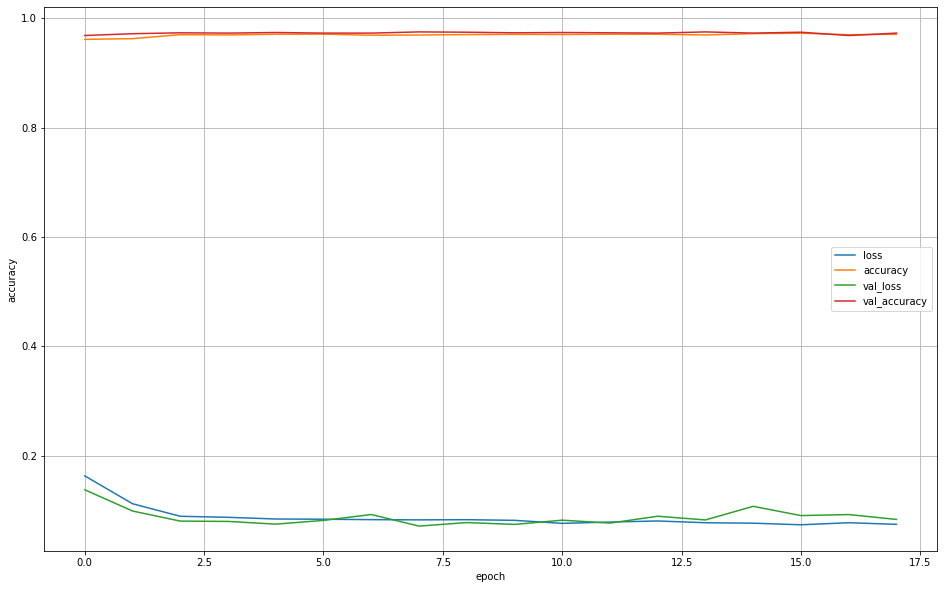

In [119]:
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# fit
log_path = "logs/" + dt.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = k.callbacks.TensorBoard(log_dir=log_path, histogram_freq=1)
es = EarlyStopping(monitor="val_loss", patience=10, mode="auto", verbose=2)

history = model.fit(x_train, y_train, validation_split=0.1, batch_size=6, epochs=1000, verbose=1, callbacks=[es]) # callbacks=[es, tensorboard_callback])
print(history)

# plot
pd.DataFrame(history.history).plot(figsize=(16,10), grid=1, xlabel="epoch", ylabel="accuracy")
plt.show()

In [120]:
# save model
model_name =  "model/light_detector_" + dt.now().strftime("%Y%m%d-%H%M%S") + ".h5"
model.save(model_name)

## 5. evaluate & predict model

In [121]:
# evauate model
# model_name = "/home/z/PycharmProjects/light_onoff_detector/model/light_detector_20210811-135021.h5"
model = k.models.load_model(model_name)
loss, acc = model.evaluate(x_test, y_test, verbose=1)
# print(f'test_loss: {loss} test_accuracy: {acc}')

97/97 [==============================] - 0s 928us/step - loss: 0.0576 - accuracy: 0.9803


In [122]:
predict = model.predict(x_test)
predicted = np.argmax(predict, axis=1)
# y1 = np.argmax(y_test, axis=1) # for one-hot encoding
# draw_CM(y1, predicted)

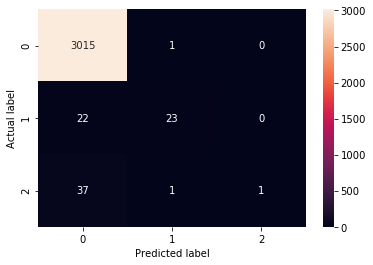

true rate:  3039
false rate:  61

========== classification_report:  
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3016
           1       0.92      0.51      0.66        45
           2       1.00      0.03      0.05        39

    accuracy                           0.98      3100
   macro avg       0.97      0.51      0.57      3100
weighted avg       0.98      0.98      0.97      3100

========== multilabel_to_binary_matrics by class_num:  
 [[TN / FP] [FN / TP]] 
 [[[  25   59]
  [   1 3015]]

 [[3053    2]
  [  22   23]]

 [[3061    0]
  [  38    1]]]


(None, None, None, None, None, None)

In [123]:
# CM
draw_CM(y_test, predicted)

/tmp/ipykernel_22760/291916241.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


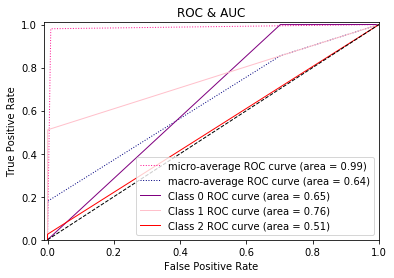

In [124]:
# ROC, AUC
x = label_binarize(predicted, classes=class_list)
y = label_binarize(y_test, classes=class_list)

draw_ROC_AUC(x, y, class_list)

In [77]:
# ROC, AUC
draw_ROC_AUC(predicted, y_test, classes)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [45]:
# # launch tensorboard @ localhost:6006
# %tensorboard --logdir logs/ --host localhost --port 6006

In [ ]:
# df.to_csv("data.csv", index=False)